In [43]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline
from PhysicsDatasets import SHODatasetXV
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import json
from matplotlib.colors import LogNorm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
from model import GPT, GPTConfig
name = "11Dec24_1819"
src = f"trainings/random_SHO_noContext_{name}/"
with open(f"{src}/model_cfg.json","r") as fin:
    model_cfg = json.load(fin)
with open(f"{src}/training_cfg.json","r") as fin:
    train_cfg = json.load(fin)

dt = train_cfg['dt']
k = train_cfg['k']
pin_amplitude = train_cfg['pin_amplitude']
min_amplitude = train_cfg['min_amplitude']
k_context = train_cfg['k_context']
# define model
gpt_config = GPTConfig(**model_cfg)
model = GPT(gpt_config)
model.load_state_dict(torch.load(f"{src}/random_SHO_noContext_{name}_best.pt",map_location='cpu'))
model.eval()

number of parameters: 0.39M


GPT(
  (transformer): ModuleDict(
    (wte): Linear(in_features=2, out_features=64, bias=True)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-7): 8 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=64, out_features=192, bias=False)
          (c_proj): Linear(in_features=64, out_features=64, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=64, out_features=256, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=256, out_features=64, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=64, out_features=2, bias=False)
)

In [45]:
masses = torch.arange(1,11.1,0.1)
max_seq_length = 65
n_seq = 20
val_data = SHODatasetXV(masses=masses,seq_len=max_seq_length,dt=dt,k=k, pin_amplitude=pin_amplitude,min_amplitude=min_amplitude,k_context=k_context)

x = val_data.xv
ctx = val_data.context

tstart = 20
nstep = max_seq_length - tstart
xcurr = x[:,:tstart,:]
with torch.no_grad():
    for i in range(nstep):
        x_next = model(xcurr)
        xcurr = torch.cat([xcurr,x_next[:,-1:,:]],dim=1)

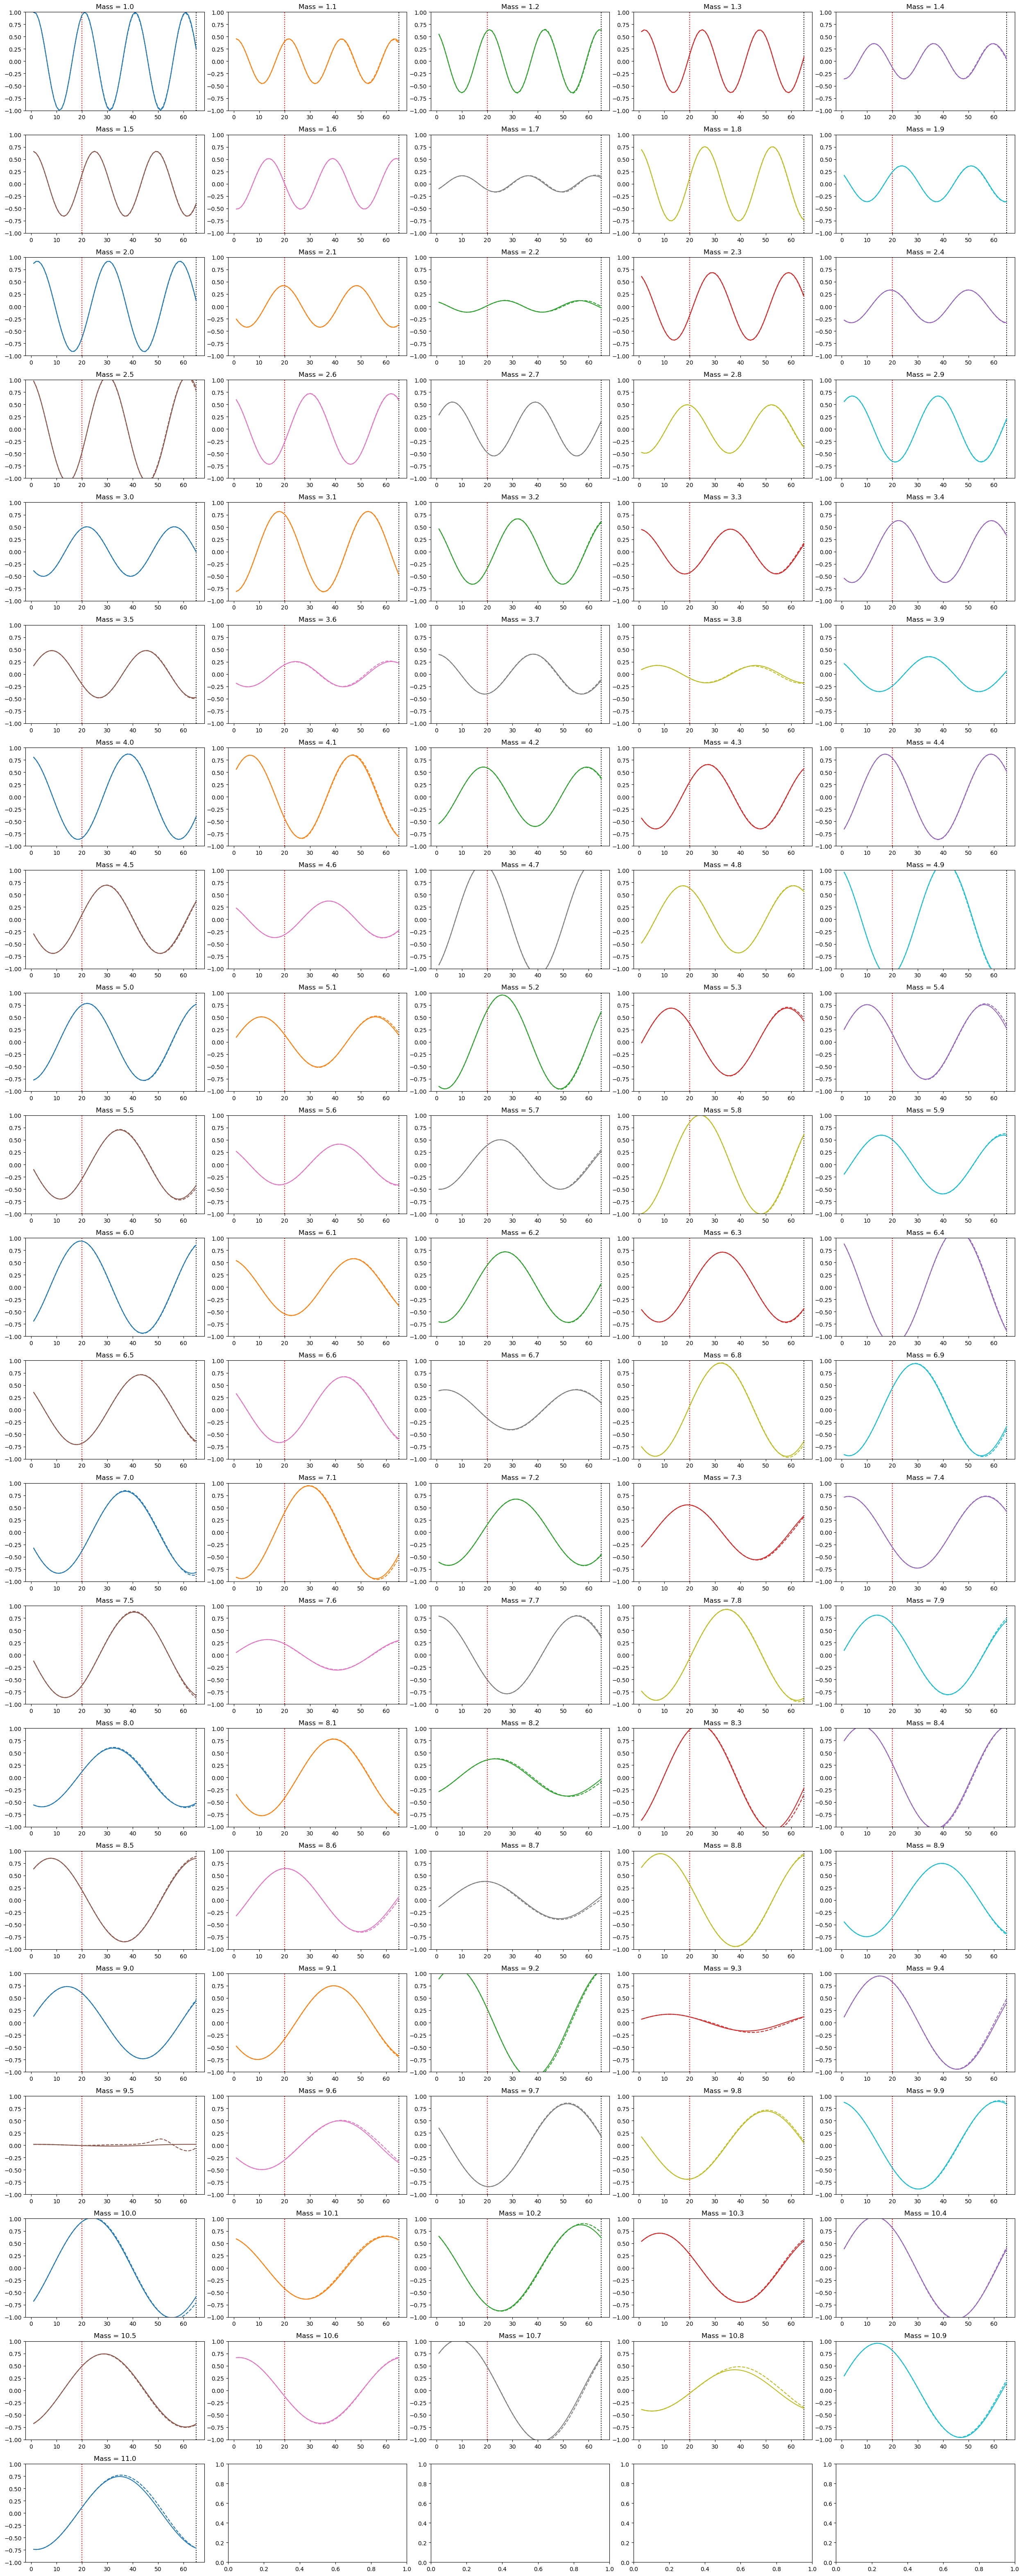

In [46]:
%matplotlib inline
import math

xref = x[:,:,0]
vref = x[:,:,1]
xpred = xcurr[:,:,0]
vpred = xcurr[:,:,1]
tref = np.arange(xref.shape[-1])+1
tpred = np.arange(xpred.shape[-1])+1

masses = val_data.masses
n_mass = len(masses)
n_col = 5
n_row = math.ceil(n_mass/n_col)

fig,axes = plt.subplots(n_row,n_col,figsize=(5*n_col,3*n_row))

for idx in range(xref.shape[0]):
    irow = idx//n_col
    icol = idx % n_col
    plt.sca(axes[irow,icol])
    plt.plot(tref,xref[idx:idx+1].T,color=f"C{idx}",zorder=1)
    plt.plot(tpred,xpred[idx:idx+1].T,linestyle='--',color=f"C{idx}",zorder=1)
    plt.ylim([-1,1])
    plt.title(f"Mass = {masses[idx]:.1f}")
    plt.axvline(max_seq_length,color='k',linestyle=':',zorder=0)
    plt.axvline(tstart,color='red',linestyle=':',zorder=0)
plt.tight_layout()
#plt.savefig("allMasses_timeSeries_smallTest_noPosEnc.png")

## check NTP MSE loss versus mass

In [47]:
masses = torch.arange(1,10.05,0.05)
max_seq_length = 50
n_seq = 20
val_data = SHODatasetXV(masses=masses,seq_len=max_seq_length,dt=dt,k=k,x0=0,pin_amplitude=pin_amplitude,min_amplitude=min_amplitude,k_context=k_context)

x = val_data.xv
ctx = val_data.context

ctx_lengths = np.arange(2,50)
mses_mean = []
mses_final = []
with torch.no_grad():
    for ctl in ctx_lengths:
        xcurr = x[:,:ctl,:]
        xnext = model(xcurr)
        mse = torch.sum((x[:,1:ctl+1,:]-xnext)**2,dim=-1,keepdims=True)
        mses_mean.append(mse.mean(dim=1))
        mses_final.append(mse[:,-1,:])
mses_mean = torch.cat(mses_mean,dim=1)
mses_final = torch.cat(mses_final,dim=1)

Text(0, 0.5, 'mean MSE of next (x,v) prediction')

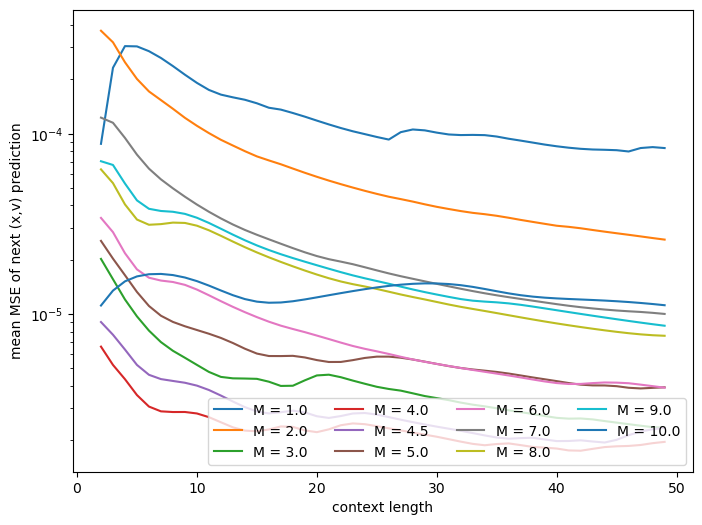

In [48]:
plt.figure(figsize=(8,6))
msel = np.concatenate([np.arange(1,5),np.array([4.5]),np.arange(5,11)])
for i,m in enumerate(masses):
    if m.item() not in msel:
        continue
    plt.plot(ctx_lengths,mses_mean[i].numpy(),label=f"M = {m:.1f}")
plt.yscale('log')
plt.legend(loc='lower right',ncol=4)
plt.xlabel("context length")
plt.ylabel("mean MSE of next (x,v) prediction")

Text(0, 0.5, 'MSE of last pos prediction')

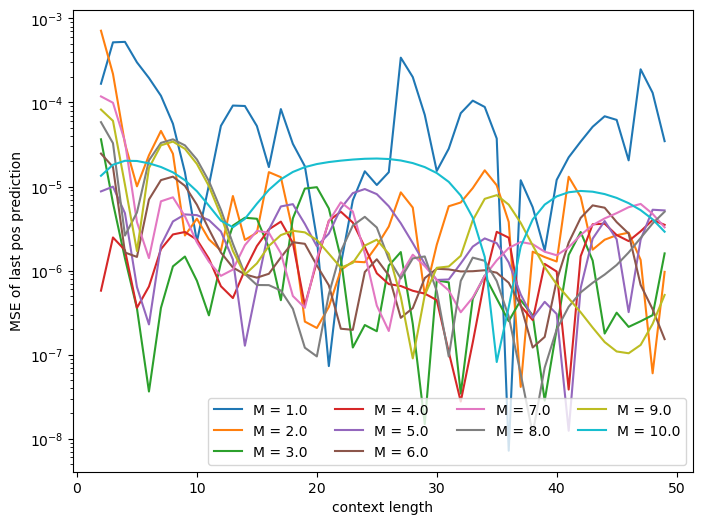

In [49]:
plt.figure(figsize=(8,6))
msel = np.arange(1,11)
for i,m in enumerate(masses):
    if m.item() not in msel:
        continue
    plt.plot(ctx_lengths,mses_final[i].numpy(),label=f"M = {m:.1f}")
plt.yscale('log')
plt.legend(loc='lower right',ncol=4)
plt.xlabel("context length")
plt.ylabel("MSE of last pos prediction")

Text(0.5, 1.0, 'x0=0')

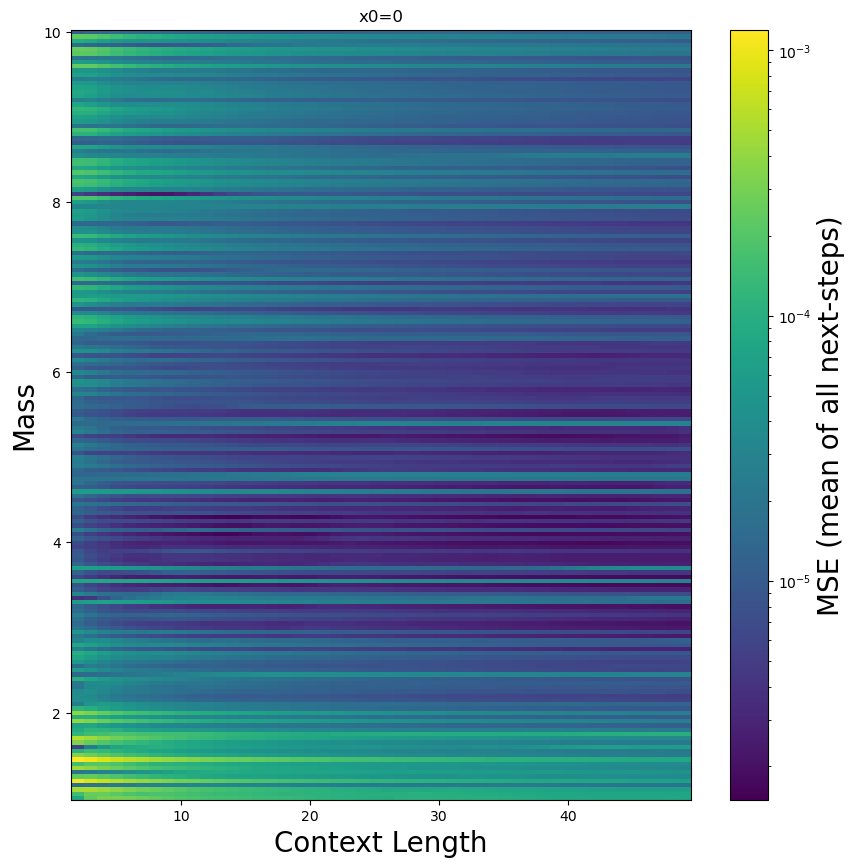

In [50]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,10))
extent = [ctx_lengths[0]-0.5*(ctx_lengths[1]-ctx_lengths[0]),ctx_lengths[-1]+0.5*(ctx_lengths[1]-ctx_lengths[0])] + [masses[0]-0.5*(masses[1]-masses[0]),masses[-1]+0.5*(masses[1]-masses[0])]
plt.imshow(mses_mean,origin='lower',aspect='auto',norm=LogNorm(),extent=extent,cmap='viridis')
cb = plt.colorbar()
cb.set_label(label='MSE (mean of all next-steps)', fontsize=20)
plt.ylabel("Mass",fontsize=20)
plt.xlabel("Context Length",fontsize=20)
#t=plt.xticks(np.arange(0.5,10.5,0.5),rotation=25)
plt.title("x0=0")

Text(0.5, 1.0, 'x0 = 0')

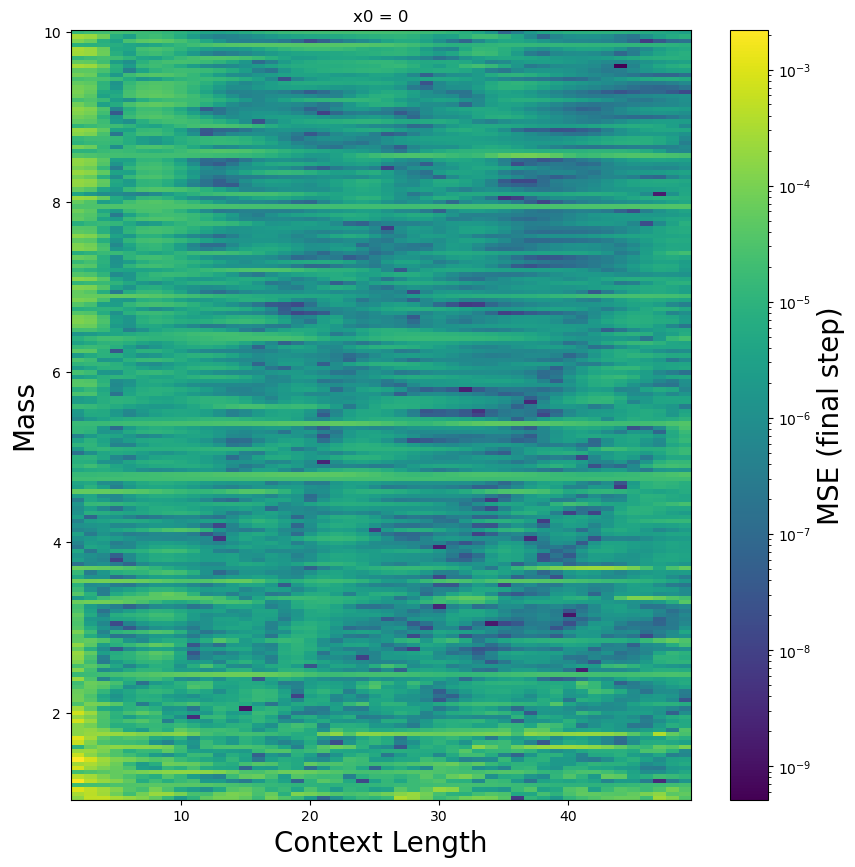

In [51]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,10))
extent = [ctx_lengths[0]-0.5*(ctx_lengths[1]-ctx_lengths[0]),ctx_lengths[-1]+0.5*(ctx_lengths[1]-ctx_lengths[0])] + [masses[0]-0.5*(masses[1]-masses[0]),masses[-1]+0.5*(masses[1]-masses[0])]
plt.imshow(mses_final,origin='lower',aspect='auto',norm=LogNorm(),extent=extent,cmap='viridis')
cb = plt.colorbar()
cb.set_label(label='MSE (final step)', fontsize=20)
plt.ylabel("Mass",fontsize=20)
plt.xlabel("Context Length",fontsize=20)
#t=plt.xticks(np.arange(0.5,10.5,0.5),rotation=25)
plt.title("x0 = 0")

## mass vs context length, but averaged over (x0,v0)

In [52]:
masses = np.arange(1,10.5,0.5)
ctx_lengths = np.arange(1,65)
max_seq_length = 65

mse_mtx = np.zeros((len(masses),len(ctx_lengths)))
mse_mean_mtx = np.zeros((len(masses),len(ctx_lengths)))
for i,m in enumerate(masses):
    data = SHODatasetXV(masses=m,num_trajectories=100,seq_len=max_seq_length,dt=dt,k=k,pin_amplitude=pin_amplitude,min_amplitude=min_amplitude,k_context=k_context)
    ctx = data.context
    with torch.no_grad():
        for j,ctl in enumerate(ctx_lengths):
            xcurr = data.xv[:,:ctl,:]
            xnext = model(xcurr)
            mse = torch.mean(torch.sum((data.xv[:,1:ctl+1,:]-xnext)**2,dim=-1),dim=0) # average across random initializations (x0,v0)
            mse_mtx[i,j] = mse[-1] # final step
            mse_mean_mtx[i,j] = mse.mean() # all next-step predictions
            #mse_last = torch.sum((data.xv[:,ctl,:]-xnext[:,-1,:])**2,dim=-1)
            #mse_last = torch.mean(mse_last)
            #mse_mtx[i,j] = mse_last

Text(0.5, 1.0, 'x0 = 0')

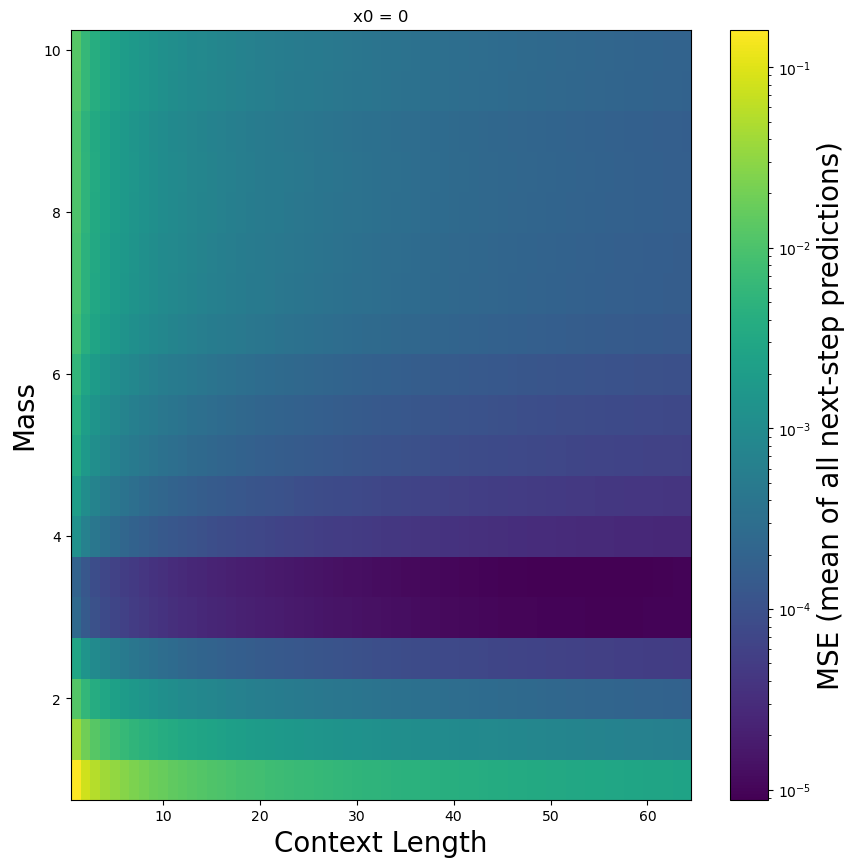

In [53]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,10))
extent = [ctx_lengths[0]-0.5*(ctx_lengths[1]-ctx_lengths[0]),ctx_lengths[-1]+0.5*(ctx_lengths[1]-ctx_lengths[0])] + [masses[0]-0.5*(masses[1]-masses[0]),masses[-1]+0.5*(masses[1]-masses[0])]
plt.imshow(mse_mean_mtx,origin='lower',aspect='auto',norm=LogNorm(),extent=extent,cmap='viridis')
cb = plt.colorbar()
cb.set_label(label='MSE (mean of all next-step predictions)', fontsize=20)
plt.ylabel("Mass",fontsize=20)
plt.xlabel("Context Length",fontsize=20)
#t=plt.xticks(np.arange(0.5,10.5,0.5),rotation=25)
plt.title("x0 = 0")

Text(0.5, 1.0, 'x0 = 0')

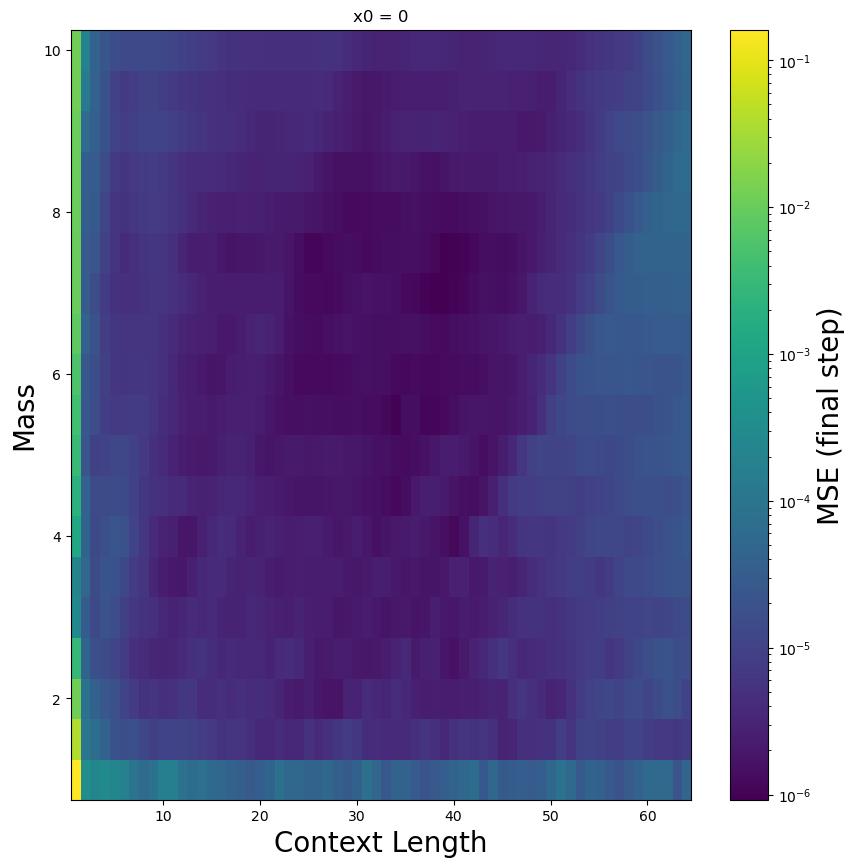

In [54]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,10))
extent = [ctx_lengths[0]-0.5*(ctx_lengths[1]-ctx_lengths[0]),ctx_lengths[-1]+0.5*(ctx_lengths[1]-ctx_lengths[0])] + [masses[0]-0.5*(masses[1]-masses[0]),masses[-1]+0.5*(masses[1]-masses[0])]
plt.imshow(mse_mtx,origin='lower',aspect='auto',norm=LogNorm(),extent=extent,cmap='viridis')
cb = plt.colorbar()
cb.set_label(label='MSE (final step)', fontsize=20)
plt.ylabel("Mass",fontsize=20)
plt.xlabel("Context Length",fontsize=20)
#t=plt.xticks(np.arange(0.5,10.5,0.5),rotation=25)
plt.title("x0 = 0")

Text(0.5, 1.0, '$M \\in [1.00,9.50]$')

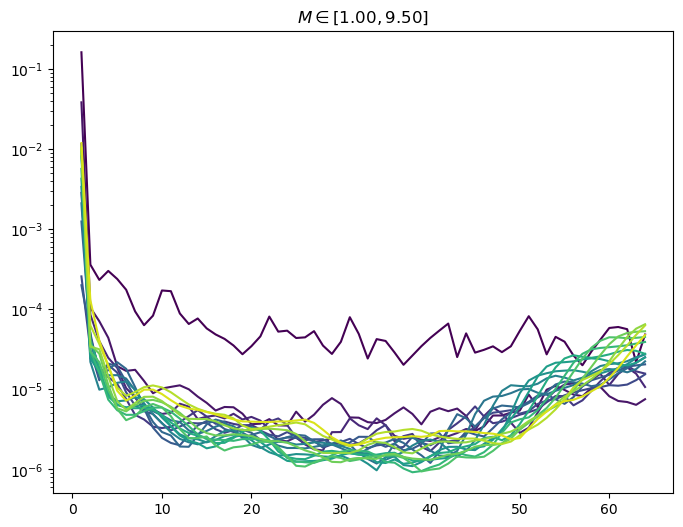

In [55]:
from matplotlib.cm import get_cmap
plt.figure(figsize=(8,6))
cmap = plt.get_cmap('viridis')
imin = 0
imax = -1
ms = masses[imin:imax]
N = ms.shape[0]
for i,m in enumerate(ms):
    T = 2*np.pi*np.sqrt(m/k)/dt
    #plt.axvline(T,color=cmap(i/N),linestyle='--',zorder=0)
    plt.plot(np.arange(len(ctx_lengths))+1,mse_mtx[i+imin],color=cmap(i/N),zorder=1)
    plt.yscale('log')
plt.title(f"$M \\in [{masses[imin]:.2f},{masses[imax-1]:.2f}]$")

Text(0.5, 1.0, '$M \\in [1.00,9.50]$')

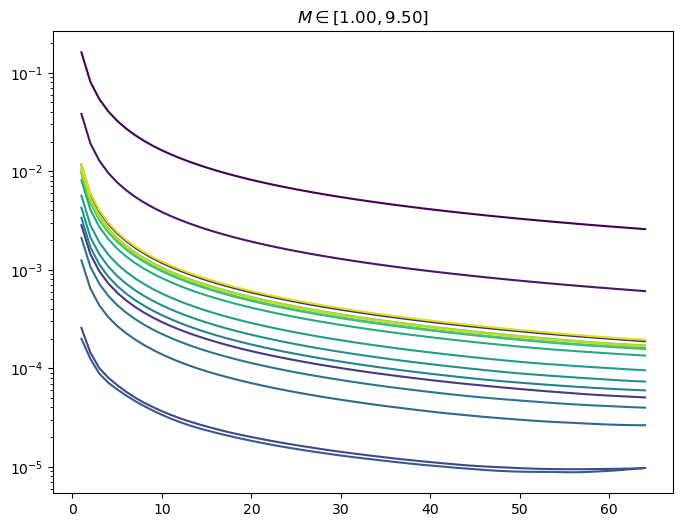

In [56]:
from matplotlib.cm import get_cmap
plt.figure(figsize=(8,6))
cmap = plt.get_cmap('viridis')
imin = 0
imax = -1
ms = masses[imin:imax]
N = ms.shape[0]
for i,m in enumerate(ms):
    T = 2*np.pi*np.sqrt(m/k)/dt
    #plt.axvline(T,color=cmap(i/N),linestyle='--',zorder=0)
    plt.plot(np.arange(len(ctx_lengths))+1,mse_mean_mtx[i+imin],color=cmap(i/N),zorder=1)
    plt.yscale('log')
plt.title(f"$M \\in [{masses[imin]:.2f},{masses[imax-1]:.2f}]$")